<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D3_ModelFitting/W1D3_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 1, Day 3, Tutorial 4
# Model Fitting: Multiple linear regression 

#Tutorial Objectives

This is Tutorial 4 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of linear models by  generalizing to multiple linear regression (Tutorial 4). We then move on to polynomial regression (Tutorial 5). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 6) and two common methods for model selection, AIC and Cross Validation (Tutorial 7).

In this tutorial, we will generalize our linear model to incorporate multiple linear features. 
- Learn how to structure our inputs for multiple linear regression using the 'Design Matrix'
- Generalize the MSE for multiple features using the ordinary least squares estimator
- Visualize our data and model fit in multiple dimensions

# Setup

In [1]:
# @title  Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

# Multiple Linear Regression


Video available at https://youtube.com/watch?v=uQjKnlhGEVY


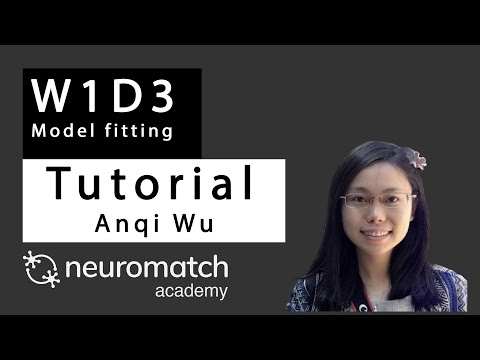

In [3]:
#@title Video: Multiple Linear Regression
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="uQjKnlhGEVY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now that we have considered the univariate case and how to produce confidence intervals for our estimator, we turn now to the general linear regression case, where we can have more than one regressor, or feature, in our input.

Recall that our original univariate linear model was given as

\begin{align}
y = \theta_0 + \theta_1 x
\end{align}

where $\theta_0$ is the intercept, $\theta_1$ is the slope. We can easily extend this to the multivariate scenario by adding another parameter for each additional feature

\begin{align}
y = \theta_0 + \theta_1 x_1 + \theta_1 x_2 + ... +\theta_d x_d
\end{align}

where $d$ is the dimensionality (number of features) in our input.

We can condense this succinctly using vector notation for a single data point

\begin{align}
y_i = \boldsymbol{\theta}^{\top}\mathbf{x}_i
\end{align}

and fully in matrix form

\begin{align}
\mathbf{y} = \mathbf{X}\boldsymbol{\theta}
\end{align}

where $\mathbf{y}$ is a vector of measurements, $\mathbf{X}$ is a matrix containing the feature values (columns) for each input sample (rows), and $\boldsymbol{\theta}$ is our parameter vector.

This matrix $\mathbf{X}$ is often referred to as the "[design matrix](https://en.wikipedia.org/wiki/Design_matrix)".

For this tutorial we will focus on the two-dimensional case ($d=2$), which allows us to fully explore the multivariate case while still easily visualizing our results. As an example, think of a situation where a scientist records the spiking response of a retinal ganglion cell to patterns of light signals that vary in contrast and in orientation.

In this case our model can be writen as

\begin{align}
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \epsilon
\end{align}

or in matrix form where

\begin{align}
\mathbf{X} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2} \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots & \vdots \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix}, 
\boldsymbol{\theta} =
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\end{bmatrix}
\end{align}

For our actual exploration dataset we shall set $\boldsymbol{\theta}=[0, -2, -3]$ and draw $N=40$ noisy samples from $x \in [-2,2)$. Note that setting the value of $\theta_0 = 0$ effectively ignores the offset term.

In [4]:
np.random.seed(121)
theta = [0, -2, -3]
n_samples = 40
n_regressors = len(theta)
x = np.random.uniform(-2, 2, (n_samples, n_regressors))
noise = np.random.randn(n_samples)
y = x @ theta + noise

Now that we have our dataset, we want to find an optimal vector of paramters $\boldsymbol{\hat\theta}$. Recall our analytic solution to minimizing MSE for a single regressor:

\begin{align}
\hat\theta = \sum_i \frac{x_i y_i}{x_i^2}.
\end{align}

The same holds true for the multiple regressor case, only now expressed in matrix form

\begin{align}
\boldsymbol{\hat\theta} = (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}.
\end{align}

This is called the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS) estimator.

### Exercise: Ordinary Least Squares Estimator

In this exercise you will implement the OLS approach to estimating $\boldsymbol{\hat\theta}$ from the design matrix $\mathbf{X}$ and measurement vector $\mathbf{y}$. You can the `@` symbol for matrix multiplication, `.T` for transpose, and `np.linalg.inv` for matrix inversion.


In [5]:
def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)
  
  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  ######################################################################
  ## TODO for students: solve for the optimal parameter vector using OLS
  ######################################################################
  # comment this out when you've filled
  raise NotImplementedError("Student excercise: solve for theta_hat vector using OLS")
  return theta_hat

In [6]:
# to_remove solution
def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)
  
  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  theta_hat = np.linalg.inv(x.T @ x) @ x.T @ y
  return theta_hat

In [7]:
theta_hat = ordinary_least_squares(x, y)
theta_hat

array([ 0.27846561, -2.01651235, -3.14249005])

Now that we have our $\mathbf{\hat\theta}$, we can obtain $\mathbf{\hat y}$ and thus our mean squared error.

In [8]:
y_hat = x @ theta_hat
print(f"MSE = {np.mean((y - y_hat)**2):.2f}")

MSE = 0.57


Finally, the following code will plot a geometric visualization of the data points (blue) and fitted plane. You can see that the residuals (green bars) are orthogonal to the hyperplane.

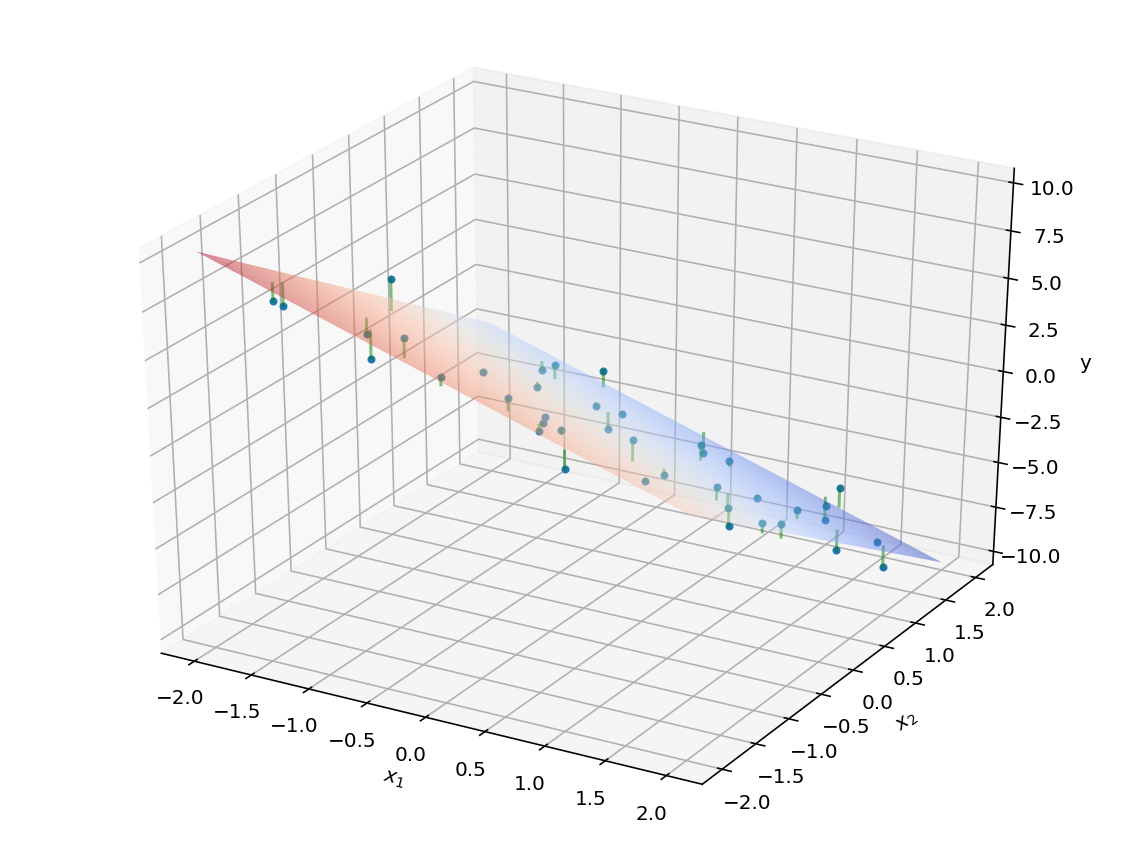

In [9]:
xx, yy = np.mgrid[-2:2:50j, -2:2:50j]
y_hat_grid = np.array([xx.flatten(), yy.flatten()]).T @ theta_hat[1:]
y_hat_grid = y_hat_grid.reshape((50, 50))

ax = plt.subplot(projection='3d')
ax.plot(x[:,1], x[:,2], y, '.')
ax.plot_surface(xx, yy, y_hat_grid, linewidth=0, alpha=0.5, color='C1',
                cmap=plt.get_cmap('coolwarm'))

for i in range(len(x)):
  ax.plot((x[i, 1], x[i, 1]),
          (x[i, 2], x[i, 2]),
          (y[i], y_hat[i]),
          'g-', alpha=.5)

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()


# Summary
- linear regression generalizes naturally to multiple dimensions
- linear algebra affords us the mathematical tools to reason and solve such problems beyond the two dimensional case

**NOTE** in practice, multidimensional least squares problems can be solve very efficiently (thanks to numerical routines such as LAPACK).